<a href="https://colab.research.google.com/github/bleamer/eva5/blob/master/w4/MNIST_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MNIST classification using CNN in PYTORCH
The following notebook CNN for classifying images in the MNIST image dataset.

The process uses near constant channel architecture and we are able to achieve a **~99%** accuracy by using **~ 11K** parameters

In [106]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [107]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 3, padding=1) #input -? OUtput? RF
        self.batch1 = nn.BatchNorm2d(10)
        self.dropout1 = nn.Dropout(0.1)        

        ## Increase the no. of kernels / transition layer
        self.conv2 = nn.Conv2d(10, 10, 3, padding=1)
        self.batch2 = nn.BatchNorm2d(10)
        self.dropout2 = nn.Dropout(0.1)        

        self.pool1 = nn.MaxPool2d(2, 2)
        
        ## Increase the no. of kernels / transition layer
        self.conv3 = nn.Conv2d(10, 16, 3, padding=1)
        self.batch3 = nn.BatchNorm2d(16)
        self.dropout3 = nn.Dropout(0.1)        

        self.conv4 = nn.Conv2d(16, 16, 3, padding=1)
        self.batch4 = nn.BatchNorm2d(16)
        self.dropout4 = nn.Dropout(0.1)        

        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.conv5 = nn.Conv2d(16, 16, 3)
        self.batch5 = nn.BatchNorm2d(16)
        self.dropout5 = nn.Dropout(0.1)        
        
        self.conv6 = nn.Conv2d(16, 16, 3)
        self.batch6 = nn.BatchNorm2d(16)
        self.dropout6 = nn.Dropout(0.1)        

        ## Reduce the no. of kernels / to required classes
        # self.gap1 = nn.AvgPool2d(kernel_size=(2,2))
        self.conv7 = nn.Conv2d(16, 10, 3)



    def forward(self, x):
        x = F.relu(self.dropout1(self.batch1(self.conv1(x))))
        x = F.relu(self.dropout2(self.batch2(self.conv2(x))))
        x = self.pool1(x)

        x = F.relu(self.dropout3(self.batch3(self.conv3(x))))
        x = F.relu(self.dropout4(self.batch4(self.conv4(x))))
        x = self.pool2(x)
        # x = self.gap1(x)

        x = F.relu(self.dropout5(self.batch5(self.conv5(x))))
        x = F.relu(self.dropout6(self.batch6(self.conv6(x))))

        # x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        # x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        # x = F.relu(self.conv6(F.relu(self.conv5(x))))
        x = self.conv7(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [108]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]             100
       BatchNorm2d-2           [-1, 10, 28, 28]              20
           Dropout-3           [-1, 10, 28, 28]               0
            Conv2d-4           [-1, 10, 28, 28]             910
       BatchNorm2d-5           [-1, 10, 28, 28]              20
           Dropout-6           [-1, 10, 28, 28]               0
         MaxPool2d-7           [-1, 10, 14, 14]               0
            Conv2d-8           [-1, 16, 14, 14]           1,456
       BatchNorm2d-9           [-1, 16, 14, 14]              32
          Dropout-10           [-1, 16, 14, 14]               0
           Conv2d-11           [-1, 16, 14, 14]           2,320
      BatchNorm2d-12           [-1, 16, 14, 14]              32
          Dropout-13           [-1, 16, 14, 14]               0
        MaxPool2d-14             [-1, 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [109]:


torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [110]:
from tqdm import tqdm
train_loss_history = []
test_loss_history = []
test_history=[]
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
        train_loss_history.append(loss.item())

def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            iter_loss = F.nll_loss(output, target, reduction='sum').item()
            test_loss +=  iter_loss # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            test_loss_history.append(iter_loss)

    test_loss /= len(test_loader.dataset)

    print('\nEpoch {}: Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        epoch, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_history.append((test_loss, 100. * correct / len(test_loader.dataset)))

In [111]:

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 19):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader, epoch)

  0%|          | 0/469 [00:00<?, ?it/s]


Epoch 1: Test set: Average loss: 0.0653, Accuracy: 9809/10000 (98.09%)



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch 2: Test set: Average loss: 0.0566, Accuracy: 9823/10000 (98.23%)



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch 3: Test set: Average loss: 0.0376, Accuracy: 9884/10000 (98.84%)



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch 4: Test set: Average loss: 0.0293, Accuracy: 9915/10000 (99.15%)



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch 5: Test set: Average loss: 0.0243, Accuracy: 9928/10000 (99.28%)



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch 6: Test set: Average loss: 0.0277, Accuracy: 9921/10000 (99.21%)



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch 7: Test set: Average loss: 0.0316, Accuracy: 9901/10000 (99.01%)



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch 8: Test set: Average loss: 0.0251, Accuracy: 9929/10000 (99.29%)



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch 9: Test set: Average loss: 0.0215, Accuracy: 9943/10000 (99.43%)



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch 10: Test set: Average loss: 0.0218, Accuracy: 9934/10000 (99.34%)



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch 11: Test set: Average loss: 0.0220, Accuracy: 9939/10000 (99.39%)



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch 12: Test set: Average loss: 0.0200, Accuracy: 9935/10000 (99.35%)



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch 13: Test set: Average loss: 0.0191, Accuracy: 9945/10000 (99.45%)



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch 14: Test set: Average loss: 0.0209, Accuracy: 9943/10000 (99.43%)



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch 15: Test set: Average loss: 0.0240, Accuracy: 9935/10000 (99.35%)



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch 16: Test set: Average loss: 0.0222, Accuracy: 9929/10000 (99.29%)



  0%|          | 0/469 [00:00<?, ?it/s]


Epoch 17: Test set: Average loss: 0.0200, Accuracy: 9943/10000 (99.43%)



loss=0.0350983701646328 batch_id=468: 100%|██████████| 469/469 [00:20<00:00, 22.47it/s]



Epoch 18: Test set: Average loss: 0.0179, Accuracy: 9945/10000 (99.45%)



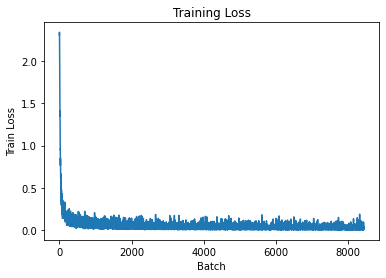

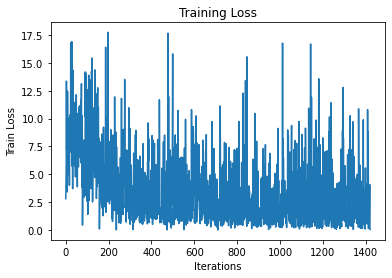

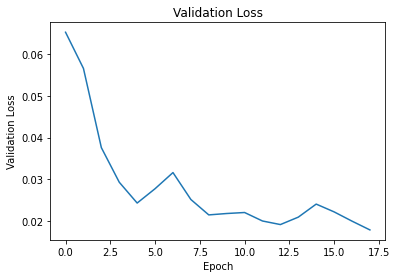

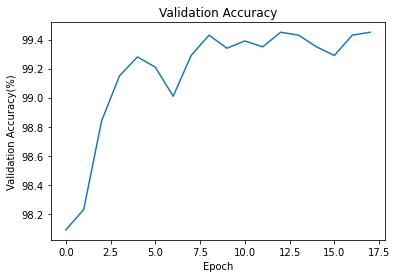

In [113]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(train_loss_history);
ax.set(xlabel='Batch', ylabel='Train Loss', title='Training Loss')
plt.show()
fig, ax = plt.subplots()
ax.plot(test_loss_history);
ax.set(xlabel='Iterations', ylabel='Train Loss', title='Training Loss');

plt.show()
fig, ax = plt.subplots();
ax.plot(list(zip(*test_history))[0]);
ax.set(xlabel='Epoch', ylabel='Validation Loss', title='Validation Loss');

plt.show()
fig, ax = plt.subplots();
ax.plot(list(zip(*test_history))[1]);
ax.set(xlabel='Epoch', ylabel='Validation Accuracy(%)', title='Validation Accuracy');

